# **Cálculo del Precio de Paridad de Importación (PPI)**


---


El Precio de Paridad de Importación es un estadístico de elaboración propia, diseñado para mostrar el costo económico de los combustibles líquidos. La serie de este estadístico contiene valores desde enero del 2019 hasta la fecha.

El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos de los componentes del PPI y, además, generar 2 figuras: la primera da cuenta de la evolución del PPI nacional; la segunda, en tanto, exhibe un análisis para provincias seleccionadas.

El PPI se compara con el precio doméstico (o *precio en el surtidor*, aquél que se verifica en la venta al público) para observar la brecha existente entre los precios de venta y el costo de importación.

Como resultado del análisis de datos, se presentan dos figuras: la primera, en forma de gráfico de líneas, muestra la evolución del precio doméstico *vis-à-vis* el precio de paridad de importación, para cada uno de los productos, en forma de promedio nacional; la segunda, en tanto, permite visualizar las realidades disímiles de la dinámica de precios en 4 jurisdicciones seleccionadas: Buenos Aires, Capital Federal, Córdoba y Corrientes.

## Preliminar

### Lectura de archivos `.pdf`

Para la ejecución del siguiente código, se debe instalar el *package* `tabula-py`, necesario para la lectura de tablas en formato `.pdf`.

In [1]:
!pip install tabula-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 51.9 MB/s eta 0:00:00


### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [2]:
import pandas as pd
import tabula
import datetime as dt
from datetime import date
import io
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import plotly.graph_objects as go
import numpy as np
import requests
import zipfile
import plotly.express as px
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [3]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.4 MB/s eta 0:00:00


### Eludir controles de *scraping*

Muchas de las páginas utilizadas en el presente documento para recopilación de información tienen prevención de robots de *scraping*.

Estos controles se eluden introduciendo el *header* definido en `header` como *value* de un *key* (`'User-Agent': header`)

In [4]:
header = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36 Edg/108.0.1462.54'

## Componentes

El precio de paridad de importación se construye a partir de diversas bases de datos de distintas fuentes (en su mayoría, organismos estatales).

### Precios internacionales

#### Obtención y limpieza de datos

Los precios internacionales de los productos (Gas Oil y Nafta) son un componente constitutivo del cálculo del Precio de Paridad de Importación.

Los datos sobre los precios internacionales son publicados mensualmente por la Energy Information Administration (EIA) de Estados Unidos.

Particularmente, se utiliza el archivo que contiene los precios futuros de los productos, y se utiliza siempre el contrato de duración más corta.

El link `url_internacionales` refiere al archivo "NYMEX Futures Prices". Son de particular interés: para el Gas Oil, el "No. 2 Heating Oil" y, para la Nafta, la "RBOB Regular Gasoline", ambos productos extraídos del puerto de Nueva York.

In [5]:
url_internacionales = "https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_M.xls"

El *DataFrame* `rbob` contiene los datos de la lectura de la hoja "Data 3" del archivo (correspondiente a los datos de la RBOB Regular Gasoline), ignorando las primeras 159 filas y utilizando la primera y segunda columna.

In [6]:
rbob = pd.read_excel(url_internacionales, sheet_name="Data 3", usecols=[0, 1], skiprows=159)

Se renombran las columnas del *DataFrame*.

In [7]:
rbob.columns = ["Período", "RBOB"]

El *DataFrame* `n2_ho` contiene los datos de la lectura de la hoja "Data 3" del archivo (correspondiente a los datos del No. 2 Heating Oil), ignorando las primeras 470 filas y utilizando la primera y segunda columna.

In [8]:
n2_ho = pd.read_excel(url_internacionales, sheet_name="Data 4", usecols=[0, 1], skiprows=470)

Se renombran las columnas del *DataFrame*.

In [9]:
n2_ho.columns = ["Período", "N2_HO"]

#### *DataFrame* final

Mediante el comando `.merge()` se unen ambos *DataFrames*, utilizando como guía la columna "Período". El *DataFrame* resultante se denomina `internacionales`.

In [10]:
internacionales = rbob.merge(n2_ho, on="Período")

Se convierte en formato `datetime` a la columna "Período", y se reemplazan todos los días por el primer día de cada mes.

In [11]:
internacionales["Período"] = pd.to_datetime(internacionales["Período"]).apply(lambda x: x.replace(day=1))

### Tipo de cambio

#### Obtención y limpieza de datos

El valor del tipo de cambio se extrae directamente de la serie del Tipo de Cambio Nominal Promedio Mensual (TCNPM), publicada por el Banco Central de la República Argentina.

In [12]:
url_tc = "https://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/com3500.xls"

La serie de TCNPM se lee con la *library* `pandas`.

In [13]:
tc = pd.read_excel(
    url_tc,
    sheet_name="Serie de TCNPM",
    skiprows=1,
    usecols=["Mes", "Tipo de cambio nominal promedio mensual"]).drop([0]).rename(
        columns = {
            "Mes": "Período",
            "Tipo de cambio nominal promedio mensual": "TCN"
            })

#### *DataFrame* final

Se recorta el *DataFrame* para que incluya solo los valores deseados (desde la fila 202 en adelante, `tc[202::]`) y se resetea el índice con el comando `.reset_index(drop=True)`.

El archivo `tc` es el *DataFrame* de la serie mensual del tipo de cambio nominal.

In [14]:
tc = tc[202::].reset_index(drop=True)

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [15]:
tc.head()

,Período,TCN
0,2019-01-01 00:00:00,37.4069
1,2019-02-01 00:00:00,38.4086
2,2019-03-01 00:00:00,41.3624
3,2019-04-01 00:00:00,43.2338
4,2019-05-01 00:00:00,44.9332


### Biocombustibles



#### Obtención de datos

La Secretaría de Energía de la Nación publica los datos mensuales del precio del biodiesel y del bioetanol. Los links de `url_biodiesel` y `url_bioetanol` refieren a los reportes de precio de cada biocombustible.

In [16]:
url_biodiesel = "https://glp.se.gob.ar/biocombustible/reporte_precios.php"

In [17]:
url_bioetanol = "https://glp.se.gob.ar/biocombustible/reporte_precios_bioetanol.php"

Dado que la información es publicada en el lenguaje `php`, se define la función `request_biocombustibles` para obtener la información de cada uno de los sitios web.

Los parámetros de la función son:
*   `url`: link de la página web (`.php`) de la cual extraer los datos
*   `data`: lista vacía donde almacenar los datos extraídos.

**Importante**: para evitar errores de permisos no otorgados, y dado que la página de la Secretaría de Energía detecta y previene el uso de robots de *scraping*, es preciso especificar el *header* previamente guardado.

In [18]:
def request_biocombustibles(url, data):
  req = Request(
    url,
    headers = {
      'User-Agent': header
      }
  )
  page = urlopen(req)
  html_parser = BeautifulSoup(page, "lxml")
  tables = html_parser.findAll('tr')
  for tr in tables:
    row_data = []
    for td in tr.findAll('td'):
        row_data.append(td.text)
    data.append(row_data)
  return data

La función se divide en dos partes:
1.   `Request`: se *abre* la página web especificada y se guardan todas las tablas contenidas en ella.
2.   `Iteration`: se itera sobre cada una de las tablas y se guarda en la lista vacía (`data`).

##### Biodiesel

Se crea la lista vacía `biodiesel_data`, donde se almacenará la información correspondiente.

In [19]:
biodiesel_data = []

Se ejecuta la función `request_biocombustibles` para la página web que contiene los precios del biodiesel.

In [20]:
biodiesel_data = request_biocombustibles(url_biodiesel, biodiesel_data)

Por último, se convierte la información a un *DataFrame* con el comando `pd.DataFrame()`. 

In [21]:
biodiesel = pd.DataFrame(biodiesel_data)

##### Bioetanol

El procedimiento para la página web del bioetanol es idéntico. Primeramente, se crea la lista vacía `bioetanol_data`.

In [22]:
bioetanol_data = []

Se ejecuta la función `request_biocombustibles` para la página web que contiene los precios del bioetanol.

In [23]:
bioetanol_data = request_biocombustibles(url_bioetanol, bioetanol_data)

Y se convierte la información a un *DataFrame*

In [24]:
bioetanol = pd.DataFrame(bioetanol_data)

#### *Data cleaning*

##### Biodiesel

Se eliminan columnas (con `NaN`) y filas innecesarias.

In [25]:
biodiesel.drop(biodiesel.iloc[:, 2:8], inplace=True, axis=1)

In [26]:
biodiesel = biodiesel[1:biodiesel[biodiesel[0] == "Enero 2019"].index[0]+1].reset_index(drop=True)

Se actualizan los nombres de las columnas.

In [27]:
biodiesel.columns = ["Período", "Precio"]

Se invierte la tabla y resetea el índice.

In [28]:
biodiesel = biodiesel[::-1].reset_index(drop=True)

Algunos meses del índice temporal contienen fallas, resueltas a continuación.

In [29]:
biodiesel["Período"][12] = "Octubre 2020"
biodiesel["Período"][18] = "Julio 2021"
biodiesel["Período"][32] = "Noviembre 2022"

Dado que el comando `pd.to_datetime()` funciona exclusivamente para fechas en idioma inglés, se deben cambiar los meses del índice temporal por su equivalente en ingles.

Ello se logra definiendo un *dictionary* en el que cada `key` es el mes en español (`mes`), y cada `value` es el mes en inglés (`month`).


In [30]:
mes_month = {
    "Enero": "January",
    "Febrero": "February",
    "Marzo": "March",
    "Abril": "April",
    "Mayo": "May",
    "Junio": "June",
    "Julio": "July",
    "Agosto": "August",
    "Septiembre": "September",
    "Octubre": "October",
    "Noviembre": "November",
    "Diciembre": "December"
}

Finalmente, se incorpora esta información al *DataFrame* reemplazando en la columna "Período" cada `mes` por cada `month` y se convierte la columna al formato `datetime`.

In [31]:
for mes, month in mes_month.items():
  biodiesel["Período"] = biodiesel["Período"].str.replace(mes, month, regex=False)

In [32]:
biodiesel["Período"] = pd.to_datetime(biodiesel["Período"])

Algunos de los valores de la columna "Precio" contienen referencias con asteriscos (\*). Se eliminan estas referencias.

In [33]:
biodiesel['Precio'] = biodiesel['Precio'].str.replace(" *", "", regex=False)

Los valores en `biodiesel` son interpretados como cadenas de texto (`string`). Se actualiza su *type* mediante el comand `astype()`, siendo éste actualizado a `float`.

In [34]:
biodiesel["Precio"] = biodiesel["Precio"].astype(float)

Dado que el precio del biodiesel es publicado en pesos argentinos por tonelada (\$/ton), para expresar el dato en pesos argentinos por metro cúbico (\$/m3) se debe:

*   multiplicar por su densidad ( 0.886 kg/l)
*   multiplicar por 1000


In [35]:
densidad_biodiesel = 0.886

In [36]:
biodiesel["Precio"] = biodiesel["Precio"] * densidad_biodiesel * 1000

##### Bioetanol

Se eliminan filas innecesarias.

In [37]:
bioetanol = bioetanol[1:bioetanol[bioetanol[0] == "01-2019"].index[0]+1].drop([4]).reset_index(drop=True)

Se actualizan los nombres de las columnas.

In [38]:
bioetanol.columns = ["Período", "Caña", "Maíz"]

Se invierte la tabla y resetea el índice.

In [39]:
bioetanol = bioetanol[::-1].reset_index(drop=True)

En el caso del *DataFrame* del bioetanol, las fallas contenidas en el índice temporal se deben solucionar a partir de un *loop* (comando `for`) que corrige los valores de las filas especificadas en la lista `filas_a_modificar`.

Los valores correctos se encuentran en la lista `valores_modificados`.

In [40]:
for index in bioetanol[bioetanol['Período'].str.contains('partir')].index.tolist():
  bioetanol['Período'][index] = bioetanol['Período'][index][12:]

In [41]:
bioetanol = bioetanol.drop(bioetanol[bioetanol['Período'].str.contains('vigente')].index.tolist()).reset_index(drop=True)

Se convierte la columna `"Período"` en índice temporal, con el comando `pd.to_datetime()`.

In [42]:
bioetanol['Período'] = pd.to_datetime(bioetanol['Período']).apply(lambda x: x.replace(day=1))

<ipython-input-42-a58a77863085>:1: UserWarning: Parsing '14-03-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  bioetanol['Período'] = pd.to_datetime(bioetanol['Período']).apply(lambda x: x.replace(day=1))


Mediante un *loop*, se eliminan distintos agregados, como asteríscos o comentarios, de las columnas de los precios, y se reemplazan las comas (`,`) por puntos (`.`) como separador de decimales.

Dado que el precio del bioetanol es publicado en pesos argentinos por litro (\$/l), para expresar el dato en pesos argentinos por metro cúbico (\$/m3) se multiplica el dato por 1000.

In [43]:
for column in bioetanol.columns[1:]:
  bioetanol[column] = bioetanol[column].str.replace("*", "", regex=True)
  bioetanol[column] = bioetanol[column].str.replace(r"\(.*\)","", regex=True)
  bioetanol[column] = bioetanol[column].str.replace(" ", "", regex=True)
  bioetanol[column] = bioetanol[column].str.replace(",", ".", regex=True).astype(float)
  bioetanol[column] = bioetanol[column]*1000

Finalmente, se toma el promedio entre el bioetanol a base de caña y el bioetanol a base de maíz.

In [44]:
bioetanol["Promedio"] = bioetanol[['Caña', 'Maíz']].mean(axis=1)

#### *DataFrame* final

La serie completa del precio de los biocombustibles se construye a partir de dos *dictionaries* de cada uno de los biocombustibles.

En cada caso, la `key` es el período, y el `value` es el precio.

In [45]:
biodiesel_dict = dict(zip(biodiesel["Período"].tolist(), biodiesel["Precio"].tolist()))

In [46]:
bioetanol_dict = dict(zip(bioetanol["Período"].tolist(), bioetanol["Promedio"].tolist()))

Dado que existen diferencias entre las `keys` de cada *dictionary*, éstos deben ser *mapeados* a un índice temporal que incorpore toda la información. Se denomina a este índice temporal como `biocombustibles`, y contiene los todos los meses de análisis.

Se convierte a `biocombustible` en un *DataFrame* de una sola columna.

In [47]:
biocombustibles = pd.date_range(biodiesel['Período'][0], biodiesel['Período'][len(biodiesel)-1], freq='MS').to_frame(index=False)

Se transforma dicha columna a formato `datetime`.

In [48]:
biocombustibles[0] = pd.to_datetime(biocombustibles[0])

Y se le agrega el nombre de "Período".

In [49]:
biocombustibles.columns = ["Período"]

Así, se pueden agregar al *DataFrame* distintas columnas, en particular:
*   la columna "Biodiesel" contiene los valores mapeados del *dictionary* `biodiesel_dict`
*   la columna "Bioetanol" contiene los valores mapeados del *dictionary* `bioetanol_dict`.

In [50]:
biocombustibles["Biodiesel"] = biocombustibles["Período"].map(biodiesel_dict)
biocombustibles["Bioetanol"] = biocombustibles["Período"].map(bioetanol_dict)

Los valores `NaN` deben ser eliminados con `.fillna()` utilizando el método "ffill" (o *forward-fill*), que rellena los `NaN` con la última observación válida.

In [51]:
biocombustibles = biocombustibles.fillna(method="ffill")

El archivo `biocombustibles` es el *DataFrame* de la serie mensual del precio de los biocombustibles (bioetanol y biodiesel).

A continuación, se presentan las primeras 5 filas del *DataFrame*.

### Impuestos

#### Obtención de datos

Los montos de los impuestos sobre los combustibles líquidos y sobre el dióxido de carbono se publican mensualmente en un documento publicado por la Dirección Nacional de Investigaciones y Análisis Fiscal (Subsecretaría de Ingresos Públicos - Secretaría de Hacienda).

Ante la ausencia de este dato, se puede recurrir a la búsqueda de los cuadros legislativos publicados por la Administración Federal de Ingresos Públicos (AFIP).

El link `url_impuestos` refiere al primer documento, que contiene los montos de los impuestos hasta el mes de febrero del año 2023 (inclusive).

In [52]:
url_impuestos = "https://www.argentina.gob.ar/sites/default/files/impuestos_sobre_los_combustibles_al_28-02-2023.pdf"

A partir del link del documento, mediante `Request` y `urlopen`, se *abre* la página web especificada (esto es, se *abre* el archivo `.pdf`). Luego, el comando `.read()` lee el archivo `.pdf` abierto.

Nuevamente, se incluye dentro de la `Request` el *header* especificado, para evitar errores de permisos no otorgados.

In [53]:
req_impuestos = Request(
    url_impuestos,
    headers = {
      'User-Agent': header
      }
  )

pdf_impuestos = urlopen(req_impuestos)

pdf_impuestos = pdf_impuestos.read()

##### Impuesto a los combustibles líquidos

A partir de la *library* `tabula`, se crea un *DataFrame* con los montos del impuesto a los combustibles líquidos (ICL) desde el año 2019. Corresponde a la página 2 del archivo `.pdf` abierto y leído.

In [54]:
ICL = tabula.read_pdf(io.BytesIO(pdf_impuestos), pages=[2])

Mar 30, 2023 11:05:21 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Mar 30, 2023 11:05:21 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>



##### Impuesto al dióxido de carbono

Igual procedimiento para los montos del impuesto al dióxido de carbono (ICO). Corresponde a la página 3 del archivo `.pdf` abierto y leído.

In [55]:
ICO = tabula.read_pdf(io.BytesIO(pdf_impuestos), pages=[3])

#### Data cleaning

##### General

Dado que las tablas encontradas en el archivo `.pdf` son similares, se define una función (`impuesto_extract`) que obtenga solo los valores deseados para cada impuesto.

Los parámetros de esta función son:
*   `df`: *DataFrame* del que se extraen los datos.
*   `productos`: lista de todos los nombres de los productos sobre los que se aplica el impuesto.
*   `split_min_1`, `split_max_1`, `split_min_2` y `split_max_2`: índices para el recorte de filas.
*   `productos_seleccionados`: lista que contiene los nombres de los productos con exenciones impositivas o regímenes diferenciales.

In [56]:
def impuesto_extract(df, productos, split_min_1, split_max_1,
                     split_min_2, split_max_2, productos_seleccionados):
  df = df[0][20::].dropna(subset=['Unnamed: 0']).reset_index(drop=True)

  df = df.rename(columns={
  df.columns[0]: "Desde-Hasta",
  df.columns[2]: productos[1]
  })
  
  df[productos[split_min_1:split_max_1]] = df[df.columns[3]].apply(lambda x: pd.Series(str(x).split(" ")))
  if split_min_2 != None:
    df[productos[split_min_2:split_max_2]] = df[df.columns[5]].apply(lambda x: pd.Series(str(x).split(" ")))

  df["Desde"] = pd.to_datetime(df["Desde-Hasta"].str.split(" ").apply(lambda x: x[0]), dayfirst=True)
  df["Hasta"] = pd.to_datetime(df["Desde-Hasta"].str.split(" ").apply(lambda x: x[1]), dayfirst=True)
  
  df['Período'] = df[['Desde', 'Hasta']].apply(lambda x: pd.date_range(x['Desde'], x['Hasta'], freq="MS"), axis=1)
  df = df.explode('Período').drop(['Desde-Hasta'], axis=1)
  df = df.reset_index(drop=True)

  df.insert(0, 'Período', df.pop('Período'))

  for column in df.columns[1:]:
    if column not in productos_seleccionados:
      df = df.drop([column], axis=1)
    else:
      df[column] = df[column].str.replace(',','.')
      df[column] = df[column].str.replace('-','0')
      df[column] = df[column].astype(float)
      df[column] = df[column] * 1000

  return df

Asimismo, los productos sobre los que se aplican el ICL y el ICO son similares.

En el caso del ICL, los productos se replican en la lista `productos_ICL`.

In [57]:
productos_ICL = [
  "NAFTAS SIN PLOMO, HASTA 92 RON", 
  "NAFTAS SIN PLOMO, DE MAS DE 92 RON",
  "NAFTAS VIRGEN",
  "GASOLINA NATURAL O DE PIROLISIS",
  "SOLVENTE",
  "AGUARRAS",
  "GASOIL",
  "DIESEL OIL",
  "KEROSENE",
  "GASOIL ZE",
  "DIESEL OIL ZE",
  "KEROSENE ZE"
]

Para el cálculo del PPI, solo se precisa el monto a pagar por ICL de las naftas de más de 92 RON, del gasoil y del gasoil comercializado en la Zona Exenta (Ver art. 7, inc. d), de la Ley Nº 23.966). Estos productos se encuentran en la lista `seleccionados_ICL`.

In [58]:
seleccionados_ICL = [
    productos_ICL[1], 
    productos_ICL[6],
    productos_ICL[9]
]

Los productos sobre los que aplica el ICO se replican en la lista `productos_ICO`.

In [59]:
productos_ICO = productos_ICL.copy()

productos_a_modificar = ["FUEL OIL", "COQUE DE PETRÓLEO", "CARBON MINERAL"]

for column, producto in zip(range(9, 12), productos_a_modificar):
  productos_ICO[column] = producto

Nuevamente, solo algunos de los productos son tratados diferencialmente, definidos en `seleccionados_ICO`.

In [60]:
seleccionados_ICO = [
    productos_ICO[1], 
    productos_ICO[6]
]

##### Impuesto a los combustibles líquidos

Se ejecuta la función `impuesto_extract` utilizando como argumentos las listas `productos_ICL` y `seleccionados_ICL`.

In [61]:
ICL = impuesto_extract(ICL, productos_ICL, 2, 8, 9, 13, seleccionados_ICL)

Para facilitar el trabajo posterior, se renombran las columnas.

In [62]:
ICL = ICL.rename(
  columns={
  ICL.columns[1]: "ICL N",
  ICL.columns[2]: "ICL GO",
  ICL.columns[3]: "ICL GO ZE"
  }
)

Se especifica que el valor del ICL para la Nafta en la Zona Exenta es de 0 pesos.

In [63]:
ICL['ICL N ZE'] = 0

Por último, se elimina/n la/s filas problemáticas.

In [64]:
ICL = ICL.drop([28]).reset_index(drop=True)

##### Impuesto al dióxido de carbono

Análogamente, se ejecuta la función `impuesto_extract` utilizando como argumentos las listas `productos_ICO` y `seleccionados_ICO`.

In [65]:
ICO = impuesto_extract(ICO, productos_ICO, 2, 10, None, None, seleccionados_ICO)

Nuevamente, se renombran las columnas.

In [66]:
ICO = ICO.rename(
  columns={
  ICO.columns[1]: "ICO N",
  ICO.columns[2]: "ICO GO"
  }
)

Dado que la tabla original contiene omisiones, algunos valores en el *DataFrame* son erróneos. Se modifican manualmente.

In [67]:
ICO[ICO.columns[1]][0] = 545
ICO[ICO.columns[1]][1] = 545
ICO[ICO.columns[2]][0] = 626
ICO[ICO.columns[2]][1] = 626
ICO[ICO.columns[0]][37] = pd.to_datetime("2021-12-01")

<ipython-input-67-46d9a0b9cbcc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICO[ICO.columns[1]][0] = 545
<ipython-input-67-46d9a0b9cbcc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICO[ICO.columns[1]][1] = 545
<ipython-input-67-46d9a0b9cbcc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICO[ICO.columns[2]][0] = 626
<ipython-input-67-46d9a0b9cbcc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Por último, se elimina/n la/s filas problemáticas.

In [68]:
ICO = ICO.drop([24, 28, 48], axis=0).reset_index(drop=True)

#### DataFrame final

Se juntan ambos *DataFrames* en un único *DataFrame* llamado `impuestos`.

El archivo `impuestos` es el *DataFrame* de la serie mensual del monto fijo de los impuestos al combustible líquido (ICL) y al dióxido de carbono (ICO).

In [69]:
impuestos = ICL.merge(ICO, on="Período")

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [70]:
impuestos.head()

,Período,ICL N,ICL GO,ICL GO ZE,ICL N ZE,ICO N,ICO GO
0,2019-01-01,8903.0,5491.0,2972.0,0,545.0,626.0
1,2019-02-01,8903.0,5491.0,2972.0,0,545.0,626.0
2,2019-03-01,9388.0,5773.0,3317.0,0,608.0,699.0
3,2019-04-01,9936.0,6128.0,3317.0,0,608.0,699.0
4,2019-05-01,9936.0,6128.0,3317.0,0,608.0,699.0


### Índice de flete terrestre

#### Obtención y limpieza de datos

El Índice de flete terrestre es un índice de costos de transporte, que -a partir del estudio de cada uno de los insumos del rubro del transporte- genera una aproximación a las variaciones mensuales del costo del transporte.

La serie histórica más completa y actualizada de este índice se encuentra en el archivo "Índices de costos logísticos y de transporte automotor de cargas", publicado por el Observatorio Nacional de Datos de Transporte (ONDaT) de la Universidad Tecnológica Nacional.

El link `url_indice` refiere a la última versión de dicha publicación.

In [71]:
url_indice = "http://ondat.fra.utn.edu.ar/wp-content/uploads/2021/09/Indice_FADEEAC_012022.xlsx"

Con la *library* `pandas`, se lee la hoja "2.1.5.1" del archivo correspondiente, ignorando las primeras 12 filas y recortando el *DataFrame* hasta la fila 122.

In [72]:
flete = pd.read_excel(url_indice, sheet_name="2.1.5.1", skiprows=12, usecols=["Unnamed: 0", "Unnamed: 1", "Unnamed: 13"])[0:122]

Se actualiza el nombre de las columnas del *DataFrame*.

In [73]:
flete.columns = ["Año", "Mes", "Índice de flete terrestre"]

Los valores `NaN` deben ser eliminados con `.fillna()` utilizando el método "ffill" (o *forward-fill*), que rellena los `NaN` con la última observación válida.

In [74]:
flete = flete.fillna(method="ffill")

Se crea la columna "Período", que es una conjunción entre las columnas "Mes" y "Año".

In [75]:
flete["Período"] = flete["Mes"].astype(str) + " - " + flete["Año"].astype(str)

Al igual que en el caso de los biocombustibles, se deben cambiar los meses del índice temporal por su equivalente en ingles.

Con `mes_month` ya definido, se reemplaza cada valor en forma de cadena de texto.

In [76]:
for mes, month in mes_month.items():
  flete["Período"] = flete["Período"].str.replace(mes, month, regex=False)

Finalmente, se convierte la columna "Período" a formato `datetime`.

In [77]:
flete["Período"] = pd.to_datetime(flete["Período"])

Se eliminan columnas innecesarias.

In [78]:
flete = flete.loc[:, [flete.columns[3], flete.columns[2]]]

#### Incrementos

La publicación y difusión del archivo "Índices de costos logísticos y de transporte automotor de cargas" del ONDaT (UTN - FRA) fue discontinuada en febrero del año 2022.

Por ello, a partir de dicho mes, los incrementos mensuales del índice deben efectuarse manualmente a partir de la información publicada por la Federación Argentina de Entidades Empresarias del Autotransporte de Cargas (FADEEAC).

En este sentido, el link `url_incrementos_2022` contiene el archivo final de los incrementos mensuales del nivel general del índice durante el año

In [79]:
url_incrementos_2022 = "https://www.fadeeac.org.ar/wp-content/uploads/2023/01/ENERO-A-DICIEMBRE-2022.pdf"

El link `url_incrementos_2023` refiere al mismo archivo para los datos del año 2023.

In [80]:
url_incrementos_2023 = "https://www.fadeeac.org.ar/wp-content/uploads/2023/02/Enero-2023.pdf"

##### Obtención y limpieza de datos

Se define la función `extract_incrementos` para, a partir del link especificado en cada una de las celdas anteriores, extraer en forma de lista los incrementos de cada año.

Los parámetros de esta función son:
*   `url_incrementos`: link que remite al archivo del cual extraer la información.
*   `incrementos_list`: lista vacía donde almacenar la información recopilada.

In [81]:
def extract_incrementos(url_incrementos, incrementos_list):
  req_incrementos = Request(
    url_incrementos,
    headers = {
      'User-Agent': header
      }
  )
  incrementos_list = urlopen(req_incrementos)
  incrementos_list = incrementos_list.read()
  incrementos_list = tabula.read_pdf(io.BytesIO(incrementos_list), pages=[1])
  incrementos_list = incrementos_list[0]
  selected_rows = [2, 14]
  incrementos_list = incrementos_list.loc[selected_rows, incrementos_list.columns[6]:incrementos_list.columns[16]]
  incrementos_list = incrementos_list.iloc[1].tolist()
  incrementos_list = [incremento.replace("%", "") for incremento in incrementos_list]
  incrementos_list = [incremento.replace(",", ".") for incremento in incrementos_list]
  incrementos_list = [float(incremento) for incremento in incrementos_list]
  return incrementos_list

Se definen dos listas vacías, una para almacenar los incrementos del año 2022 (`incrementos_2022`) y otra para el 2023 (`incrementos_2023`).

In [82]:
incrementos_2022, incrementos_2023 = [], []

Se ejecuta la función `extract_incrementos` con los parámetros antes definidos para el año 2022.

In [83]:
incrementos_2022 = extract_incrementos(url_incrementos_2022, incrementos_2022)

Dado que el valor de los incrementos del año 2023 corresponde solo al mes de enero, se explicita solamente dicho valor.

In [84]:
incrementos_2023 = [5.55, 10.02]

La totalidad de los incrementos es la suma entre ambas listas.

In [85]:
incrementos = incrementos_2022 + incrementos_2023

#### *DataFrame* final

Se agrega una nueva fila para cada uno de los valores *extras* recopilados en la lista `incrementos`.

In [86]:
for i, incremento in zip(range(len(flete), len(flete) + len(incrementos)), incrementos):
  flete.loc[i] = [pd.to_datetime(flete[flete.columns[0]][i-1]) + pd.DateOffset(months=1), 
                  flete[flete.columns[1]][i-1] * (1 + incremento/100)]

Dado que el análisis comienza en el año 2019, se eliminan filas innecesarias (anteriores a dicho año) y se reseta el índice.

In [87]:
flete = flete[85::].reset_index(drop=True)

Se efectúa un cambio de base del índice, generando un índice en base "dic. 2020 = 100".

In [88]:
flete[flete.columns[1]] = flete[flete.columns[1]] / flete[flete.columns[1]][23] * 100

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [89]:
flete.head()

,Período,Índice de flete terrestre
0,2019-01-01,51.994786
1,2019-02-01,51.880397
2,2019-03-01,56.357675
3,2019-04-01,57.710260
4,2019-05-01,59.331918


## Cálculo Precio de Paridad de Importación

Una vez definidos y computados los valores para los componentes del Precio de Paridad de Importación, se puede calular efectivamente la serie de tiempo del estadístico.

Se comienza por crear dos listas: `productos` y `productos_ZE`, que contendrán los nombres comerciales (de venta al público) de los productos, y sus variantes en la Zona Exenta de impuestos.

In [90]:
productos = ['Gas Oil Grado 2', 'Gas Oil Grado 3', 'Nafta (súper) entre 92 y 95 Ron', 'Nafta (premium) de más de 95 Ron']

In [91]:
productos_ZE = []
for producto in productos:
  productos_ZE.append(producto+" - ZE")

Además, se agrupan en una lista, `provincias`, todas las provincias que formarán parte del análisis.

In [92]:
provincias = ['BUENOS AIRES', 'CAPITAL FEDERAL', 'CORDOBA', 'CORRIENTES', 'MENDOZA', 'RIO NEGRO', 'SALTA']

Por último, se computan los márgenes minoristas para cada producto, y se los agrupa en la lista `márgenes`.

In [93]:
margen_GO2 = 0.094
margen_GO3 = 0.113
margen_NS = 0.119
margen_NP = 0.143
márgenes = [margen_GO2, margen_GO3, margen_NS, margen_NP]

### Re-cálculo de precios internacionales

Los precios internacionales (definidos en el *DataFrame* `internacionales`) son la base del cálculo del Precio de Paridad de Importación.

Dado que los precios internacionales se publican en US$ / Gal (dólares por galón americano), se deben convertir a US$ / m<sup>3</sup> (dólares por metro cúbico) utilizándose el siguiente conversor.

In [94]:
USDxgallon_to_USDxm3 = 264.1721769

Por otra parte, la calidad de los productos internacionales difiere de la calidad de los productos domésticos.

Los siguientes valores cuantifican esa diferencia, en términos de US$ / Gal.

In [95]:
quality_GO2 = -0.03
quality_GO3 = 0
quality_NS = 0.06
quality_NP = 0.12

Dichos valores se agrupan en la lista `qualities`.

In [96]:
qualities = [quality_GO2, quality_GO3, quality_NS, quality_NP]

Se agregan 4 columnas al *DataFrame* (una por cada producto doméstico), donde -para el cálculo- se tiene en cuenta la diferencia de calidad y la conversión a US$ / m<sup>3</sup>.

In [97]:
for i, int_prod in zip(range(0, len(productos)), [internacionales.columns[2]]*2 + [internacionales.columns[1]]*2):
  internacionales[productos[i]] = (internacionales[int_prod]+qualities[i])*USDxgallon_to_USDxm3

Se eliminan columnas no deseadas.

In [98]:
internacionales.drop([internacionales.columns[1], internacionales.columns[2]], axis=1, inplace=True)

Se presentan las primeras 5 filas del *DataFrame* modificado.

In [99]:
internacionales.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron
0,2019-01-01,481.057534,488.982699,381.200451,397.050782
1,2019-02-01,510.908990,518.834155,417.127867,432.978198
2,2019-03-01,518.041639,525.966804,505.889719,521.740049
3,2019-04-01,536.533691,544.458857,554.761571,570.611902
4,2019-05-01,528.608526,536.533691,537.854552,553.704883


### Cálculo de los precios CIF

El precio CIF (*cost, insurance and freight*) conjuga el costo del producto con los costos de seguro y de flete.

A continuación, se enumeran y computan los componentes del precio CIF, incluyendo alije, mermas y multas por demoras.

In [100]:
flete_y_seguro_Houston_Zarate = 48.87
alije = 0.15
seguro = 0.0008
mermas = 0.003
multas_demoras = 2.5
despachante_de_aduana = 0.15
inspector_de_calidad_y_cantidad = 0.15
otros_costos_de_internación = 2
margen_mayorista = 0
extras = multas_demoras + despachante_de_aduana + inspector_de_calidad_y_cantidad + otros_costos_de_internación + margen_mayorista

Por otro lado, se proveen las densidades del Gas Oil y de la Nafta.

In [101]:
densidad_G = 0.845
densidad_N = 0.755

Se crea un *DataFrame* vacío, `cif`, que almacenará los datos del precio CIF.

In [102]:
cif = pd.DataFrame()

Con los valores anteriormente explicitados, y a partir de los datos del *DataFrame* `internacionales`, se calcula el precio CIF.

In [103]:
for column in internacionales.columns:
  if "Gas" in column:
    cif[column] = (internacionales[column]+(flete_y_seguro_Houston_Zarate*densidad_G)*(1+alije))*(1+mermas)+extras
  elif "Nafta" in column:
    cif[column] = (internacionales[column]+(flete_y_seguro_Houston_Zarate*densidad_N)*(1+alije))*(1+mermas)+extras
  else:
    cif[column] = internacionales[column]

Se presentan las primeras 5 filas del *DataFrame* modificado.

In [104]:
cif.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron
0,2019-01-01,534.932598,542.881538,429.702724,445.600606
1,2019-02-01,564.873608,572.822549,465.737923,481.635804
2,2019-03-01,572.027655,579.976595,554.766060,570.663941
3,2019-04-01,590.575183,598.524124,603.784528,619.682409
4,2019-05-01,582.626242,590.575183,586.826787,602.724669


### Cálculo de los subtotales fósiles en US$

Para computar los subtotales fósiles en US$, se deben agregar los costos financieros y de almacenamiento y despacho, enumerados a continuación.

In [105]:
c_financiero_30d = (6.95/100)/12
almac_y_despacho = 10.35

Se crea un *DataFrame* vacío, `subtotal_fosiles_USD`, que almacenará los datos de los subtotales fósiles en US$.

In [106]:
subtotal_fosiles_USD = pd.DataFrame()

Con los valores anteriormente explicitados, y a partir de los datos del *DataFrame* `cif`, se calculan los subtotales fósiles en US$.

In [107]:
for column in cif.columns:
  if column in productos:
    subtotal_fosiles_USD[column] = cif[column]*(1+c_financiero_30d) + almac_y_despacho
  else:
    subtotal_fosiles_USD[column] = cif[column]

Se presentan las 5 primeras filas del *DataFrame*.

In [108]:
subtotal_fosiles_USD.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron
0,2019-01-01,548.380749,556.375727,442.541419,458.531376
1,2019-02-01,578.495168,586.490146,478.785321,494.775278
2,2019-03-01,585.690648,593.685627,568.329080,584.319036
3,2019-04-01,604.345598,612.340576,617.631447,633.621403
4,2019-05-01,596.350619,604.345598,600.575493,616.565449


### Cálculo de los subtotales fósiles en ARS

Para computar los subtotales fósiles en ARS, basta con multiplicar el valor de cada columna por el tipo de cambio.

Se crea un *DataFrame* vacío, `subtotal_fosiles_ARS`, que almacenará los datos de los subtotales fósiles en ARS.

In [109]:
subtotal_fosiles_ARS = pd.DataFrame()

El cálculo de los subtotales fósiles en ARS se efectúa simplemente multiplicando por el tipo de cambio de cada mes.

In [110]:
for column in subtotal_fosiles_USD.columns:
  if column in productos:
    subtotal_fosiles_ARS[column] = subtotal_fosiles_USD[column]*tc['TCN']
  else:
    subtotal_fosiles_ARS[column] = subtotal_fosiles_USD[column]

Se presentan las primeras 5 filas del *DataFrame*.

In [111]:
subtotal_fosiles_ARS.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron
0,2019-01-01,20513.223832,20812.291190,16554.102614,17152.237330
1,2019-02-01,22219.189491,22526.265419,18389.473894,19003.625750
2,2019-03-01,24225.570862,24556.262358,23507.454724,24168.837715
3,2019-04-01,26128.156703,26473.810001,26702.554434,27393.861030
4,2019-05-01,26795.941648,27155.181612,26985.778724,27704.258653


### Cálculo de los montos de anticipo de pago de impuestos

El pago de tributos nacionales implica, a su vez, el cálculo del pago de adelantos de estos impuestos.

#### Precio considerado para el pago de impuestos

Dado que solo se abonan adelantos de impuestos por los montos -en pesos- del precio "mayorista", el cálculo del precio considerado para el pago de impuestos contempla el precio internacional, el flete y el márgen mayorista.

Se crea un *DataFrame* vacío, `precio_considerado`, que almacenará los datos de los precios considerados según producto.

In [112]:
precio_considerado = pd.DataFrame()

El cálculo de los precios considerados se efectúa según lo establecido anteriormente.

In [113]:
for column in internacionales.columns:
  if column in productos:
    if "Gas" in column:
      precio_considerado[column] = (internacionales[column]+(flete_y_seguro_Houston_Zarate*densidad_G)+margen_mayorista)*tc['TCN']
    elif "Nafta" in column:
      precio_considerado[column] = (internacionales[column]+(flete_y_seguro_Houston_Zarate*densidad_N)+margen_mayorista)*tc['TCN']
  else: precio_considerado[column] = internacionales[column]

Se presentan las 5 primeras filas del *DataFrame*.

In [114]:
precio_considerado.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron
0,2019-01-01,19539.594620,19836.050486,15639.723939,16232.635671
1,2019-02-01,21209.387936,21513.782441,17438.453758,18047.242766
2,2019-03-01,23135.511997,23463.315855,22450.955172,23106.562887
3,2019-04-01,24981.736558,25324.371570,25579.641863,26264.911887
4,2019-05-01,25607.595853,25963.698891,25825.419704,26537.625779


#### Cálculo del anticipo del pago de impuestos

Primeramente, se explicitan los porcentajes para los tributos del país: Ingresos Brutos (`iibb`), Impuesto a las Ganancias (`igg`) e Impuesto al Valor Agregado (`iva`). Los porcentajes de dichos impuestos se suman en la variable `ad_valorem`.

In [115]:
iibb = 0.03
igg = 0.05
iva = 0.21
ad_valorem = iibb + igg + iva

Luego, se especifica la tasa de adelanto del pago de impuestos.

In [116]:
adelanto = 0.02209

Se crea un *DataFrame* vacío, `anticipo_impuestos`, que almacenará los datos de los montos del anticipo del pago de impuestos según producto.

In [117]:
anticipo_impuestos = pd.DataFrame()

A partir de los datos obtenidos en el *DataFrame* `precio_considerado`, se calculan los montos del anticipo de impuestos.

In [118]:
for column in precio_considerado.columns:
  if "Gas" in column:
    anticipo_impuestos["Total " + column] = (impuestos['ICL GO'] + impuestos['ICO GO'] + precio_considerado[column]*ad_valorem)*adelanto
    anticipo_impuestos["Total " + column+str(" - ZE")] = (impuestos['ICL GO ZE'] + impuestos['ICO GO'] + precio_considerado[column]*ad_valorem)*adelanto
  elif "Nafta" in column:
    anticipo_impuestos["Total " + column] = (impuestos['ICL N'] + impuestos['ICO N'] + precio_considerado[column]*ad_valorem)*adelanto
    anticipo_impuestos["Total " + column+str(" - ZE")] = (impuestos['ICL N ZE'] + impuestos['ICO N'] + precio_considerado[column]*ad_valorem)*adelanto
  else: anticipo_impuestos[column] = precio_considerado[column]

Se presentan las primeras 5 filas del *DataFrame*.

In [119]:
anticipo_impuestos.head()

,Período,Total Gas Oil Grado 2,Total Gas Oil Grado 2 - ZE,Total Gas Oil Grado 3,Total Gas Oil Grado 3 - ZE,Total Nafta (súper) entre 92 y 95 Ron,Total Nafta (súper) entre 92 y 95 Ron - ZE,Total Nafta (premium) de más de 95 Ron,Total Nafta (premium) de más de 95 Ron - ZE
0,2019-01-01,260.297127,204.652417,262.196253,206.551543,308.895956,112.228686,312.694207,116.026937
1,2019-02-01,270.993990,215.349280,272.943972,217.299262,320.418799,123.751529,324.318762,127.651492
2,2019-03-01,291.174883,236.921843,293.274828,239.021788,364.634704,157.253784,368.834593,161.453673
3,2019-04-01,310.843933,248.748943,313.038887,250.943897,396.782704,177.296464,401.172612,181.686372
4,2019-05-01,314.853250,252.758260,317.134481,255.039491,398.357181,178.870941,402.919645,183.433405


### Cálculo de los totales fósiles en ARS

Los montos correspondientes a los totales fósiles en ARS se construyen a partir de los datos recopilados en los *DataFrames* `subtotal_fosiles_ARS` y `anticipo_impuestos`.

Se crea un *DataFrame* vacío, `total_bases_ARS`, que almacenará los montos totales de las bases fósiles en ARS.

In [120]:
total_bases_ARS = pd.DataFrame()

Los montos totales de las bases fósiles en ARS se calculan teniendo en cuenta los subtotales de las bases fósiles y los anticipos de impuestos.

In [121]:
for column in subtotal_fosiles_ARS.columns:
  if column != subtotal_fosiles_ARS.columns[0]:
    total_bases_ARS[column] = subtotal_fosiles_ARS[column]
    total_bases_ARS[column+" - ZE"] = subtotal_fosiles_ARS[column]
  else: total_bases_ARS[column] = subtotal_fosiles_ARS[column]

for col_base in total_bases_ARS.columns:
  for col_impuesto in anticipo_impuestos.columns:
    if ("ZE" not in col_base and col_impuesto == str("Total " + col_base)):
        total_bases_ARS[col_base] = total_bases_ARS[col_base] + anticipo_impuestos[col_impuesto]
    elif ("ZE" in col_base and col_impuesto == str("Total " + col_base)):
      total_bases_ARS[col_base] = total_bases_ARS[col_base] + anticipo_impuestos[col_impuesto]
    else: total_bases_ARS[col_base] = total_bases_ARS[col_base]

Se presentan las 5 primeras filas del *DataFrame*.

In [122]:
total_bases_ARS.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 2 - ZE,Gas Oil Grado 3,Gas Oil Grado 3 - ZE,Nafta (súper) entre 92 y 95 Ron,Nafta (súper) entre 92 y 95 Ron - ZE,Nafta (premium) de más de 95 Ron,Nafta (premium) de más de 95 Ron - ZE
0,2019-01-01,20773.520959,20717.876249,21074.487443,21018.842733,16862.998569,16666.331299,17464.931538,17268.264268
1,2019-02-01,22490.183481,22434.538771,22799.209391,22743.564681,18709.892693,18513.225423,19327.944512,19131.277242
2,2019-03-01,24516.745746,24462.492706,24849.537185,24795.284145,23872.089428,23664.708508,24537.672307,24330.291387
3,2019-04-01,26439.000636,26376.905646,26786.848888,26724.753898,27099.337138,26879.850898,27795.033642,27575.547402
4,2019-05-01,27110.794897,27048.699907,27472.316093,27410.221103,27384.135905,27164.649665,28107.178297,27887.692057


### Cálculo de montos erogados en flete

Los montos erogados en concepto de flete dependen, por un lado, de las distancias recorridas y, por el otro, de la evolución del índice de flete terrestre, computado oportunamente en el *DataFrame* `flete`.

#### Enumeración de distancias y ponderadores

A continuación, se enumeran las distancias necesarias para el cálculo de los montos. Se trata de las distancias desde Zárate hasta las capitales provinciales (y la Capital Federal).

In [123]:
Zárate_Buenos_Aires = 153
Zárate_Capital_Federal = 95
Zárate_Córdoba = 612
Zárate_Corrientes = 834
Zárate_Mendoza = 1007
Zárate_Río_Negro = 970
Zárate_Salta = 1403

Estas distancias se agrupan en la lista `distancias_Zárate_provincias`.

In [124]:
distancias_Zárate_provincias = [Zárate_Buenos_Aires,
                                Zárate_Capital_Federal,
                                Zárate_Córdoba,
                                Zárate_Corrientes,
                                Zárate_Mendoza,
                                Zárate_Río_Negro,
                                Zárate_Salta]

Asimismo, se agrega la distancia entre San Lorenzo (Santa Fe) a Zárate (Provincia de Buenos Aires).

In [125]:
SanLorenzo_Zárate = 241

Se agregan 2 ponderadores, uno para cada tipo de biocombustible.

In [126]:
ponderador_biodiesel = 1.25
ponderador_bioetanol = 1.75

#### Cálculo de los montos

Se establece un costo fijo y un costo total, mientras que el costo variable es calculado según la distancia existente entre Zárate y la Capital Federal.

In [127]:
costo_fijo = 20
costo_total = 25
costo_variable = (costo_total - costo_fijo)/Zárate_Capital_Federal

A partir del *DataFrame* `flete`, que contiene el índice de flete terrestre, se calculan los montos erogados por fletes para los biocombustibles, agregándose 2 columnas al *DataFrame*: "Biodiesel" y "Bioetanol".

In [128]:
flete['Biodiesel'] = ((costo_fijo*tc['TCN'][23])+(costo_variable*SanLorenzo_Zárate*tc['TCN'][23]))*(flete['Índice de flete terrestre']/flete['Índice de flete terrestre'][23])*ponderador_biodiesel
flete['Bioetanol'] = ((costo_fijo*tc['TCN'][23])+(costo_variable*SanLorenzo_Zárate*tc['TCN'][23]))*(flete['Índice de flete terrestre']/flete['Índice de flete terrestre'][23])*ponderador_bioetanol

Nuevamente, a partir del *DataFrame* `flete`, se calculan los montos erogados por fletes para cada una de las provincias. Se agregan, así, 7 columnas al *DataFrame* (una por cada provincia analizada).

In [129]:
for provincia, distancia in zip(provincias, distancias_Zárate_provincias):
  flete[provincia] = ((costo_fijo*tc['TCN'][23])+(costo_variable*distancia*tc['TCN'][23]))*(flete['Índice de flete terrestre']/flete['Índice de flete terrestre'][23])

Se presentan las 5 primeras filas del *DataFrame*.

In [130]:
flete.head()

,Período,Índice de flete terrestre,Biodiesel,Bioetanol,BUENOS AIRES,CAPITAL FEDERAL,CORDOBA,CORRIENTES,MENDOZA,RIO NEGRO,SALTA
0,2019-01-01,51.994786,1755.444391,2457.622148,1205.348613,1074.184974,2243.350514,2745.390649,3136.620123,3052.946767,4032.151175
1,2019-02-01,51.880397,1751.582414,2452.215379,1202.696846,1071.821767,2238.415142,2739.350789,3129.719559,3046.230285,4023.280443
2,2019-03-01,56.357675,1902.743976,2663.841566,1306.489583,1164.319985,2431.590369,2975.756762,3399.814357,3309.119958,4370.489545
3,2019-04-01,57.710260,1948.409831,2727.773764,1337.845333,1192.263665,2489.948538,3047.174925,3481.409902,3388.538837,4475.381294
4,2019-05-01,59.331918,2003.160148,2804.424207,1375.438787,1225.766274,2559.916092,3132.800540,3579.237520,3483.756778,4601.139508


### Cálculo de los precios totales de biocombustibles

El precio total del biocombustible incorpora los anticipos de impuestos y el flete correspondiente.

In [131]:
for column in biocombustibles.columns[1:]:
  biocombustibles[column] = biocombustibles[column]*(1+adelanto) + flete[column]

Se presentan las 5 primeras filas del *DataFrame*.

In [132]:
biocombustibles.head()

,Período,Biodiesel,Bioetanol
0,2019-01-01,27420.253075,24148.416128
1,2019-02-01,26799.696742,24566.665664
2,2019-03-01,26950.858304,24778.291851
3,2019-04-01,27969.108209,25008.824719
4,2019-05-01,28933.958123,25637.403762


### Cálculo de la paridad ex-planta

Tanto la nafta como el gas oil es mezclado con biocombustibles en su proceso de elaboración.

La paridad ex-planta es un precio que conjuga los totales (en ARS) de las bases fósiles con los precios totales de los biocombustibles.

En este sentido, se enumeran los siguientes ponderadores, que refieren a los distintos "cortes" (o porcentajes de mezcla) de las bases fósiles y del biocombustible.

In [133]:
ponderador_BF_Gas_Oil = 0.9
ponderador_biocomb_Gas_Oil = 0.1
ponderador_BF_Nafta = 0.88
ponderador_biocomb_Nafta = 0.12

Se crea un *DataFrame* vacío, `paridad_ex_planta`, que almacenará los montos totales de las paridad ex-planta.

In [134]:
paridad_ex_planta = pd.DataFrame()

Los montos totales de la paridad ex-planta (en ARS) como fuera dispuesto anteriormente.

In [135]:
for column in total_bases_ARS.columns:
  if column in productos or column in productos_ZE:
    if "Gas" in column:
      paridad_ex_planta[column] = total_bases_ARS[column]*ponderador_BF_Gas_Oil + biocombustibles['Biodiesel']*ponderador_biocomb_Gas_Oil
    elif "Nafta" in column:
      paridad_ex_planta[column] = total_bases_ARS[column]*ponderador_BF_Nafta + biocombustibles['Bioetanol']*ponderador_biocomb_Nafta
    else: pass
  else: paridad_ex_planta[column] = total_bases_ARS[column]

Se presentan las 5 primeras filas del *DataFrame*.

In [136]:
paridad_ex_planta.head()

,Período,Gas Oil Grado 2,Gas Oil Grado 2 - ZE,Gas Oil Grado 3,Gas Oil Grado 3 - ZE,Nafta (súper) entre 92 y 95 Ron,Nafta (súper) entre 92 y 95 Ron - ZE,Nafta (premium) de más de 95 Ron,Nafta (premium) de más de 95 Ron - ZE
0,2019-01-01,21438.194171,21388.113932,21709.064007,21658.983768,17737.248676,17564.181479,18266.949688,18093.882491
1,2019-02-01,22921.134807,22871.054568,23199.258126,23149.177887,19412.705449,19239.638252,19956.591050,19783.523853
2,2019-03-01,24760.157002,24711.329266,25059.669297,25010.841561,23980.833719,23798.338509,24566.546652,24384.051443
3,2019-04-01,26592.011393,26536.125902,26905.074820,26849.189329,26848.475648,26655.327757,27460.688571,27267.540680
4,2019-05-01,27293.111220,27237.225729,27618.480296,27562.594805,27174.528048,26981.380157,27810.805353,27617.657462


### Cálculo del PPI provincial y nacional

El precio de paridad de importación (PPI) variará según la provincia, dado que los montos erogados en concepto de flete e impuestos varían fuertemente entre provincias.

#### Cálculo provincial

Para generalizar la construcción del precio de paridad de importación para cada provincia, se crea la función `calculo_PPI_provincia`, que resume los pasos necesarios para dicho cálculo.

In [137]:
def calculo_PPI_provincia(provincia):
  dataframe_prov = paridad_ex_planta.copy()
  for column in dataframe_prov.columns[1:]:
    if provincia != provincias[5]:
      if "ZE" in column:
        dataframe_prov.drop(column, axis=1, inplace=True)
    else:
      if "ZE" not in column:
        dataframe_prov.drop(column, axis=1, inplace=True)
  dataframe_prov['Flete terrestre'] = flete[provincia]
  dataframe_prov = dataframe_prov.merge(impuestos, on="Período")
  for column in dataframe_prov.columns:
    if provincia != provincias[5]:
      if " GO" in column:
        dataframe_prov[column] = dataframe_prov[column]*ponderador_BF_Gas_Oil
      elif " N" in column:
        dataframe_prov[column] = dataframe_prov[column]*ponderador_BF_Nafta
    else:
      if "GO ZE" in column:
        dataframe_prov[column] = dataframe_prov[column]*ponderador_BF_Gas_Oil
      elif "N ZE" in column:
        dataframe_prov[column] = dataframe_prov[column]*ponderador_BF_Nafta
      elif "ICO GO" in column:
        dataframe_prov[column] = dataframe_prov[column]*ponderador_BF_Gas_Oil
      elif "ICO N" in column:
        dataframe_prov[column] = dataframe_prov[column]*ponderador_BF_Nafta
  for column in dataframe_prov.columns:
    if provincia != provincias[5]:
      if column in productos:
        dataframe_prov['IVA - '+column] = iva*(dataframe_prov[column]+dataframe_prov['Flete terrestre'])
        dataframe_prov['IIBB - '+column] = iibb*(dataframe_prov[column]+dataframe_prov['Flete terrestre'])
        if "Gas" in column:
          dataframe_prov['Total - '+column] = dataframe_prov[column] + dataframe_prov['Flete terrestre'] + dataframe_prov['ICL GO'] + dataframe_prov['ICO GO'] + dataframe_prov['IVA - '+column] + dataframe_prov['IIBB - '+column]
        elif "Nafta" in column:
          dataframe_prov['Total - '+column] = dataframe_prov[column] + dataframe_prov['Flete terrestre'] + dataframe_prov['ICL N'] + dataframe_prov['ICO N'] + dataframe_prov['IVA - '+column] + dataframe_prov['IIBB - '+column]
    else:
      if column in productos_ZE:
        dataframe_prov['IVA - '+column] = iva*(dataframe_prov[column]+dataframe_prov['Flete terrestre'])
        dataframe_prov['IIBB - '+column] = iibb*(dataframe_prov[column]+dataframe_prov['Flete terrestre'])
        if "Gas" in column:
          dataframe_prov['Total - '+column] = dataframe_prov[column] + dataframe_prov['Flete terrestre'] + dataframe_prov['ICL GO ZE'] + dataframe_prov['ICO GO'] + dataframe_prov['IVA - '+column] + dataframe_prov['IIBB - '+column]
        elif "Nafta" in column:
          dataframe_prov['Total - '+column] = dataframe_prov[column] + dataframe_prov['Flete terrestre'] + dataframe_prov['ICL N ZE'] + dataframe_prov['ICO N'] + dataframe_prov['IVA - '+column] + dataframe_prov['IIBB - '+column]
  columns = [column for column in dataframe_prov.columns if "Total" in column]
  if provincia != provincias[5]:
    for column, producto, márgen in zip(columns, productos, márgenes):
      dataframe_prov['margen sobre ' + column] = dataframe_prov[column]*márgen
  else:
    for column, producto_ZE, márgen in zip(columns, productos_ZE, márgenes):
      dataframe_prov['margen sobre ' + column] = dataframe_prov[column]*márgen
  if provincia != provincias[5]:
    for column in dataframe_prov.columns:
      if column in productos:
        dataframe_prov['PPI - '+column] = dataframe_prov['Total - '+column] + dataframe_prov['margen sobre Total - '+column]  
  else:
    for column in dataframe_prov.columns:
      if column in productos_ZE:
        dataframe_prov['PPI - '+column] = dataframe_prov['Total - '+column] + dataframe_prov['margen sobre Total - '+column]
  for column in dataframe_prov.columns[1:]:
    if "PPI" not in column:
      dataframe_prov.drop(column, axis=1, inplace=True)
    else:
      dataframe_prov[column] = dataframe_prov[column]/1000
  if provincia == provincias[5]:
    dataframe_prov.columns = dataframe_prov.columns.str.rstrip(' - ZE')  
  dataframe_prov["provincia"] = provincia
  return dataframe_prov

Así, ejecutando la función `calculo_PPI_provincia`, se crea un *DataFrame* para cada provincia. En este caso, para la provincia de Buenos Aires.

In [138]:
PPI_BS_AS = calculo_PPI_provincia(provincias[0])

Para la Capital Federal:

In [139]:
PPI_CABA = calculo_PPI_provincia(provincias[1])

Para la provincia de Córdoba:

In [140]:
PPI_CBA = calculo_PPI_provincia(provincias[2])

Para la provincia de Corrientes:

In [141]:
PPI_CORR = calculo_PPI_provincia(provincias[3])

Para la provincia de Mendoza:

In [142]:
PPI_MZA = calculo_PPI_provincia(provincias[4])

Para la provincia de Río Negro:

In [143]:
PPI_RN = calculo_PPI_provincia(provincias[5])

Y, finalmente, para la provincia de Salta:

In [144]:
PPI_SLA = calculo_PPI_provincia(provincias[6])

#### Cálculo nacional

Primeramente, se agrupan todos los *DataFrames* provinciales creados en un conjunto de *DataFrames* llamado `PPIs`.

In [145]:
PPIs = [PPI_BS_AS, PPI_CABA, PPI_CBA, PPI_CORR, PPI_MZA, PPI_RN, PPI_SLA]

Luego, se crea un nuevo *DataFrame* que une verticalmente todos los *DataFrames* provinciales y los ordena cronológicamente y según la provincia.

In [146]:
PPI_nacional = pd.concat(PPIs).sort_values(["Período", "provincia"]).reset_index(drop=True)

### Cómputo de los precios domésticos

Los precios de paridad de importación obtenidos, computados en `PPI_nacional` pueden ser comparados con los precios domésticos de los mismos productos, relevados mensualmente dada la Resolución 1104/04 de la Secretaría de Energía de la Nación.

#### Obtención y limpieza de datos

Para extraer los datos, se debe utilizar el *dataset* de la Resolución 1104/2004. El link `url_domesticos` refiere a dicho *dataset*.

In [147]:
url_domesticos = "https://datos.gob.ar/dataset/energia-precios-volumenes-eess---resolucion-110404"

El *dataset* contiene múltiples archivos. Por ello, es necesario crear una lista (`identifiers`) con cadenas de texto que identifiquen los archivos deseados. En este caso, cada identificador es el año del archivo deseado.

In [148]:
identifiers = ['2019', '2020', '2021', '2022', '2023']

Se crea la función `domestic_extractor`, que extrae los links de los archivos deseados: aquellas que contienen cadenas de texto mencionadas en `identifiers` y que refieran a los precios de venta al público ("precios-eess").

La función tiene dos parámetros:
*   `url`: el link del cual extraer los links de los archivos.
*   `list_of_links`: lista vacía donde almacenar los links extraídos.

In [149]:
def domestic_extractor(url, list_of_links):
  req = Request(url)
  page = urlopen(req)
  html_parser = BeautifulSoup(page, "lxml")
  for link in html_parser.findAll('a'):
    if str(link.get('href')).endswith('.csv'):
      if "precios-eess" in str(link.get('href')):
        for identifier in identifiers:
          if identifier in str(link.get('href')):
            list_of_links.append(link.get('href'))
          else: pass
      else: pass
    else: pass

Se crea la lista vacía `enlisted_links`, donde almacenar los links extraídos.

In [150]:
enlisted_links = []

Se ejecuta la función `domestic_extractor` con los parámetros antes definidos.

In [151]:
domestic_extractor(url_domesticos, enlisted_links)

#### *DataFrame* final

Se crea un *DataFrame* vacío, `precio_domestico`, que servirá para concatenar cada uno de los *DataFrames* individuales.

In [152]:
precio_domestico = pd.DataFrame()

La lista `enlisted_links` contiene los links a los archivos deseados. Por tanto, se itera sobre cada uno de estos links para leer el archivo `.csv` y concatenarlo en `precio_domestico`.

In [153]:
for link in enlisted_links[::-1]:
  each_frame = pd.read_csv(link)
  each_frame = each_frame[(each_frame[each_frame.columns[12]] == 'Al público') & (each_frame[each_frame.columns[11]].isin(productos)) & (each_frame[each_frame.columns[10]].isin(provincias))]
  each_frame = each_frame.groupby(['anio', 'mes', 'provincia', 'producto'], as_index=False)['precio_surtidor'].mean()
  each_frame["Período"] = pd.to_datetime(each_frame["anio"].astype(str) + '/' + each_frame['mes'].astype(str) + '/01')
  each_frame = each_frame.drop(columns=['anio', 'mes'])
  each_frame.insert(0, 'Período', each_frame.pop('Período'))
  each_frame = each_frame.pivot(index=['Período', 'provincia'], columns='producto', values='precio_surtidor').reset_index()
  precio_domestico = precio_domestico.append(each_frame,ignore_index=True)

<ipython-input-153-a7c889ff7f9c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precio_domestico = precio_domestico.append(each_frame,ignore_index=True)
<ipython-input-153-a7c889ff7f9c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precio_domestico = precio_domestico.append(each_frame,ignore_index=True)
<ipython-input-153-a7c889ff7f9c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precio_domestico = precio_domestico.append(each_frame,ignore_index=True)
<ipython-input-153-a7c889ff7f9c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precio_domestico = precio_domestico.append(each_frame,ignore_index=True)
<ipython-input-153-a7c88

A continuación, se presentan las 5 primeras filas del *DataFrame*.

In [154]:
precio_domestico.head()

producto,Período,provincia,Gas Oil Grado 2,Gas Oil Grado 3,Nafta (premium) de más de 95 Ron,Nafta (súper) entre 92 y 95 Ron
0,2019-01-01,BUENOS AIRES,37.194206,44.066074,45.384075,39.653108
1,2019-01-01,CAPITAL FEDERAL,35.184521,41.378097,43.588011,37.623672
2,2019-01-01,CORDOBA,37.286581,43.638617,46.817896,41.856281
3,2019-01-01,CORRIENTES,38.787692,46.006627,47.756548,42.819379
4,2019-01-01,MENDOZA,35.930331,40.402192,43.511972,38.838204


### PPI vs. precio doméstico

Los *DataFrames* `PPI_nacional`, que contiene los valores del PPI para cada una de las provincias, y `precio_domestico`, que contiene el precio de venta al público en estaciones de servicio, pueden unirse utilizando como guía las columnas "Período" y "Provincia".

In [155]:
conjunto = PPI_nacional.merge(precio_domestico, on=["Período", "provincia"])

Se crea y aplica un orden especial para las columnas, para facilitar la comparativa entre productos.

In [156]:
columns_order = []
columns_order.append("Período")
columns_order.append("provincia")
for producto in productos:
  columns_order.append(producto)
  columns_order.append("PPI - "+producto)

In [157]:
conjunto = conjunto[columns_order]

Se presentan las primeras 5 filas del *DataFrame*.

In [158]:
conjunto.head()

,Período,provincia,Gas Oil Grado 2,PPI - Gas Oil Grado 2,Gas Oil Grado 3,PPI - Gas Oil Grado 3,Nafta (súper) entre 92 y 95 Ron,PPI - Nafta (súper) entre 92 y 95 Ron,Nafta (premium) de más de 95 Ron,PPI - Nafta (premium) de más de 95 Ron
0,2019-01-01,BUENOS AIRES,37.194206,36.740123,44.066074,37.752038,39.653108,35.587625,45.384075,37.101654
1,2019-01-01,CAPITAL FEDERAL,35.184521,36.562191,41.378097,37.571016,37.623672,35.405627,43.588011,36.915753
2,2019-01-01,CORDOBA,37.286581,38.148234,43.638617,39.184605,41.856281,37.027915,46.817896,38.572835
3,2019-01-01,CORRIENTES,38.787692,38.829282,46.006627,39.877481,42.819379,37.724526,47.756548,39.284387
4,2019-01-01,MENDOZA,35.930331,39.360008,40.402192,40.417424,38.838204,38.267380,43.511972,39.838884


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [159]:
conjunto.to_excel("Precio de Paridad de Importación y Precio Doméstico.xlsx", index=False)

## Figuras

### General

Los colores utilizados para ambas figuras se construyen a partir de los 4 primeros valores de `qualitative.G10`, una escala discreta de colores de Plotly.

In [160]:
colors = px.colors.qualitative.G10[0:4]

Para aplicar el mismo color al precio doméstico y al Precio de Paridad de Importación, se repite cada color dos veces.

In [161]:
colors = [y for color in colors for y in (color,)*2]

Por otra parte, se definen los nombres (y el orden) de los productos en las visualizaciones.

La lista `names_productos` itera sobre cada producto en `productos` y recopila tanto el producto como su variante de paridad de importación.

In [162]:
names_productos = []
for producto in productos:
  names_productos.append(producto)
  names_productos.append("PPI - "+producto)

Se crea la lista `legend_groups`, que contiene el orden de agrupación de las leyendas de los gráficos.

In [163]:
legend_groups = ["Gas Oil"]*4 + ["Nafta"]*4

Además, se crea la lista `dashing`, que contiene la forma (continua o discontinua) de las líneas a graficar.

In [164]:
dashing = [x for y in zip(["solid"]*4, ["dash"]*4) for x in y]

Por último, se crea la función `general_update_layout`, que modifica el aspecto general de la figura.

Los parámetros de la función son:
*   `fig`: el nombre de la figura a utilizar.
*   `bar_mode`: indica el modo de presentación de los gráficos de barra.
*   `min`: valor mínimo del eje de ordenadas.
*   `max`: valor máximo del eje de ordenadas.
*   `dtick`: longitud de la medida entre valores del eje de ordenadas.
*   `fig_number`: dígito de prueba.

In [165]:
def general_update_layout(fig, bar_mode, min, max, dtick, title_text, fig_number):
  fig.update_layout(
      margin = dict(
          b = 15,
          t = 15,
          l = 15,
          r = 50),
      barmode = bar_mode,
      height = 750, 
      width = 1000,
      plot_bgcolor = 'rgba(0,0,0,0)',
      legend = dict(
          orientation = 'h',
          xanchor = 'center', 
          x = 0.5, 
          yanchor = 'bottom', 
          y = 1,
          font = dict(
              size = 16
              )
          ),
      yaxis=dict(
        range=[min, max], title=dict(text=title_text),
        showgrid=True,
        gridcolor='lightgray',
        dtick=dtick
        ),
      font=dict(
          size=14,
          family="Serif"
          )
      )
  if fig_number == 1:
    fig.update_layout(
        xaxis = dict(
            range = [nacional_avg['Período'][0], dt.date(date.today().year, date.today().month, 15)],
            tickformat = "%m\n<b>%Y", dtick="M3",
            )
    )
  if fig_number == 2:
    fig.update_layout(
        xaxis = dict(
            range = [CS['Período'][0], 
                     dt.date(pd.to_datetime(CS["Período"][len(CS)-1]).year,
                             pd.to_datetime(CS["Período"][len(CS)-1]).month,
                             28)],
            tickformat = "%m\n<b>%Y", dtick="M3",
            )
    )

### Figura: PPI vs. precio doméstico – promedio nacional mensual

Para la creación de esta figura es necesario contar con las medias mensuales nacionales de cada producto. En este sentido, se crea el *DataFrame* `nacional_avg`, que consiste en agrupar (`.groupby()`) el *DataFrame* `conjunto` por período, y calcular los promedios mensuales de cada uno de los productos. 

In [166]:
nacional_avg = conjunto.groupby(by="Período", as_index=False)[conjunto.columns[2:]].mean()

Se crea la figura `promedio_nacional` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [167]:
promedio_nacional = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `general_update_layout` para modificar el aspecto de la figura en general.

In [168]:
for producto, color, dash, legend in zip(names_productos, colors, dashing, legend_groups):
  promedio_nacional.add_trace(
      go.Scatter(
        x=nacional_avg['Período'],
        y=nacional_avg[producto],
        mode='lines',
        name=producto,
        legendgroup=legend,
        legendgrouptitle_text=legend,
        line=dict(
            width=2,
            color=color,
            dash=dash
        )
      )
  )
  promedio_nacional.add_annotation(
    x=pd.to_datetime(nacional_avg['Período'][-1:].values[0]),
    y=nacional_avg[producto][-1:].values[0],
    text=round(nacional_avg[producto][-1:].values[0], 2).astype(str),
    font=dict(
        color=color
    ),
    xanchor="left",
    xshift=10,
    yshift=0,
    showarrow=False
  )
  promedio_nacional.add_trace(
    go.Scatter(
      showlegend=False,
      x=nacional_avg['Período'].tail(1),
      y=nacional_avg[producto].tail(1),
      mode='markers',
      name=producto+"EoP",
      marker=dict(
          color=color, size=10
      )
    )
  )

general_update_layout(promedio_nacional, None, 25, 290, 30, "<b>ARS / litro", 1)

A continuación, se exhibe la figura.

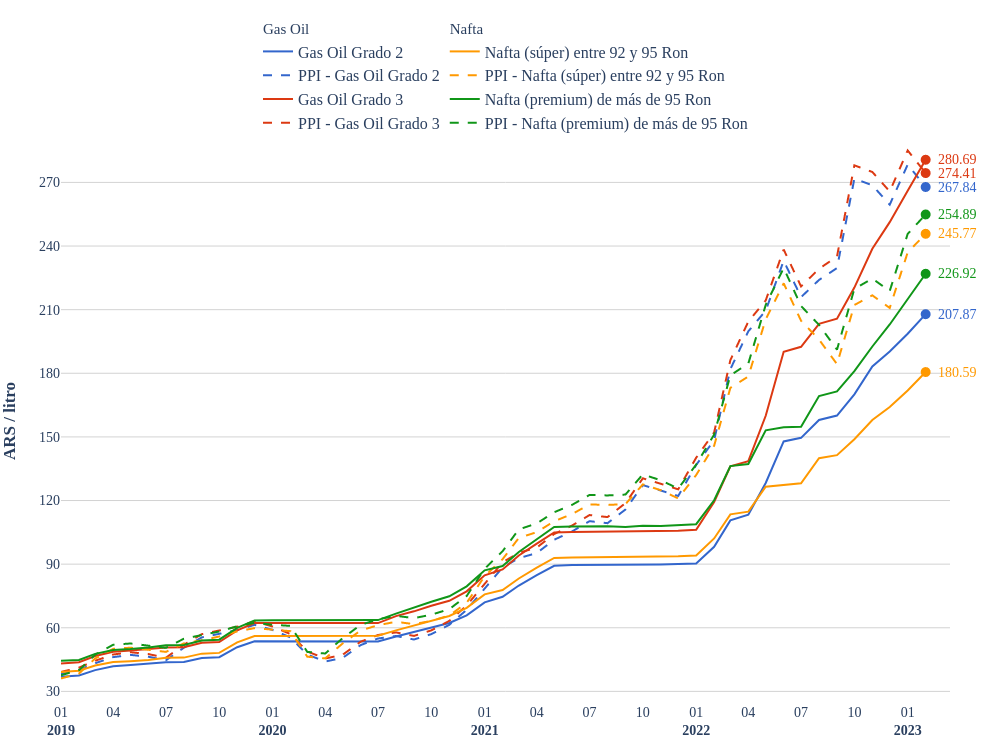

In [169]:
promedio_nacional.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [170]:
pio.write_image(promedio_nacional, "Figura PPI vs. Dom - nacional.pdf", width=3*300, height=2.25*300)

### Figura: PPI vs. precio doméstico – provincias seleccionadas

Para la creación de esta figura, se requiere explicitar los nombres de las provincias que serán visualizadas. La lista `provincias_names` contiene dichas variables. Al mismo tiempo, los nombres de las provincias servirán de eje de abscisas (categórico) del gráfico.

In [171]:
provincias_names = ['Buenos Aires', 'Capital Federal', 'Córdoba', 'Corrientes']

Se crea la figura `provincias_seleccionadas` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [172]:
provincias_seleccionadas = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `general_update_layout` para modificar el aspecto de la figura en general.

In [173]:
for column, color, legend in zip(conjunto[-7:-3].columns[2:], colors, legend_groups):
  if "PPI" not in column:
    provincias_seleccionadas.add_trace(
      go.Bar(
        name=column,
        x=provincias_names,
        y=conjunto[-7:-3][column],
        text=conjunto[-7:-3][column],
        textposition="inside",
        texttemplate="%{value:.1f}",
        marker=dict(color=color),
        legendgroup=legend,
        legendgrouptitle_text=legend,
    ))
  else:
    provincias_seleccionadas.add_trace(
      go.Scatter(
        name=column,
        x=provincias_names,
        y=conjunto[-7:-3][column],
        mode='markers+text',
        text=conjunto[-7:-3][column],
        textposition="middle right",
        texttemplate="%{text:.1f}",
        textfont=dict(color=color),
        marker=dict(size=15, color=color),
        legendgroup=legend,
        legendgrouptitle_text=legend,
    ))

general_update_layout(provincias_seleccionadas, "group", 125, 310, 10, "<b>ARS / litro", 0)

A continuación, se exhibe la figura.

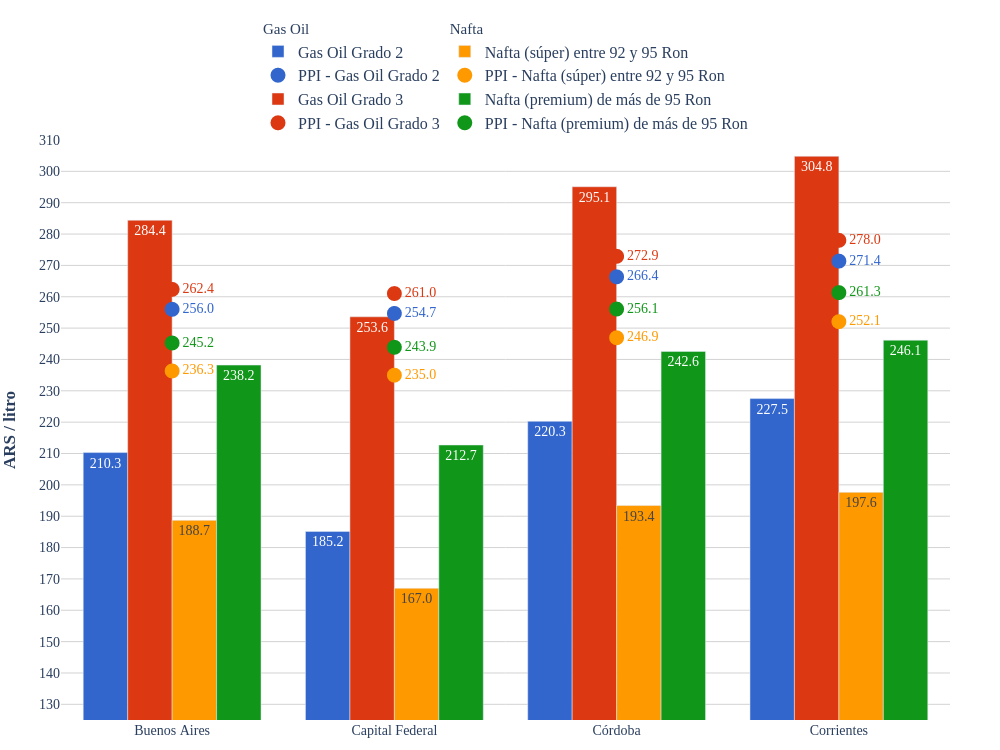

In [174]:
provincias_seleccionadas.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [175]:
pio.write_image(provincias_seleccionadas, "Figura PPI vs. Dom - provincias seleccionadas.pdf", width=3*300, height=2.25*300)

# ***Crack spread*: aproximación a los márgenes de comercialización**

---

El *crack spread* es un cálculo simplificado de los márgenes de refinación (esto es, el beneficio de las refinerías). Generalmente, se calcula como la diferencia entre el precio del petróleo crudo y el precio de los productos derivados de dicho petróleo (un *mix* de nafta y gas oil).

El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos del *crack spread* para Argentina y Estados Unidos.

Como resultado del análisis de datos, se presenta una figura que permite visualizar la evolución de los márgenes de refino en ambos países.

## Cálculo del *crack spread* para Argentina

En Argentina, el *crack spread* se calcula a partir de los precios domésticos de la nafta (súper y premium) y del gas oil (grado 2 y 3), además de los precios domésticos de los crudos nacionales (Crudo Medanito y Escalante).

### Productos derivados del petróleo

Los precios domésticos de los derivados del petróleo (nafta y gas oil) en Argentina se encuentran en el *DataFrame* `precio_domestico`, creado y modificado anteriormente para establecer comparaciones con respecto al Precio de Paridad de Importación.

El *DataFrame* `CS_ARG` se define como una copia del *DataFrame* `precio_domestico`.

In [176]:
CS_ARG = precio_domestico.copy()

En particular, para el cálculo del *crack spread* se precisan solamente aquellos precios correspondientes a Capital Federal. Así, se eliminan filas no deseadas y se resetea el índice con el comando `.reset_index(drop=True)`.

In [177]:
CS_ARG = CS_ARG[CS_ARG['provincia'] == "CAPITAL FEDERAL"].reset_index(drop=True)

Tanto el gas oil como la nafta, en Argentina, se comercializan al público en 2 modalidades: una *standard* (Gas Oil Grado 2 y Nafta (súper) entre 92 y 95 Ron) y una *premium* (Gas Oil Grado 3 y Nafta (premium) de más de 95 Ron).

Para cada derivado del petróleo, se calculan los promedios aritméticos entre calidades y se incluyen en las columnas "Gas Oil" y "Nafta".

In [178]:
CS_ARG["Gas Oil"] =  CS_ARG[[productos[0], productos[1]]].mean(axis=1)

In [179]:
CS_ARG["Nafta"] =  CS_ARG[[productos[2], productos[3]]].mean(axis=1)

Algo similar sucede con los márgenes minoristas, calculándose promedios entre calidades y creando `margen_GO` para el gas oil, y `margen_N` para la nafta.

In [180]:
margen_GO = (margen_GO2 + margen_GO3)/2

In [181]:
margen_N = (margen_NS + margen_NP)/2

Con la información recopilada, se procede a calcular el precio ex-planta de cada uno de los productos derivados del petróleo.

Así, se efectúan las siguientes operaciones:
1.   sustraer los montos de impuestos (Impuesto a los Combustibles Líquidos e Impuesto al Dióxido de Carbono) para cada producto, notados en el *DataFrame* `impuestos`.
2.   sustraer los montos erogados en concepto de fletes a Capital Federal, incluyendo el Impuesto al Valor Agregado (IVA)
3.   sustraer los montos considerados márgenes minoristas para cada producto, incluyendo el Impuesto al Valor Agregado (IVA)
4.   sustraer los montos erogados en concepto de impuestos *ad valorem* (definidos oportunamente en `ad_valorem`)

In [182]:
CS_ARG["Gas Oil"] = (CS_ARG["Gas Oil"] - impuestos['ICL GO']/1000 - impuestos['ICO GO']/1000 - flete[provincias[1]]/1000*(1+iva) - margen_GO*CS_ARG["Gas Oil"]*(1+iva)) / (1 + ad_valorem)

In [183]:
CS_ARG["Nafta"] = (CS_ARG["Nafta"] - impuestos['ICL N']/1000 - impuestos['ICO N']/1000 - flete[provincias[1]]/1000*(1+iva) - margen_N*CS_ARG["Nafta"]*(1+iva)) / (1 + ad_valorem)

Las columnas "Gas Oil" y "Nafta" representan los montos promedios equivalentes a una hipotética paridad ex-planta, y su unidad de medida es ARS / litro (pesos argentinos por litro).

Ambas columnas se convierten a US$ / bbl (dólares estadounidenses por barril) diviendo por el tipo de cambio y multiplicando por el conversor de litro a barril (`conversor_l_bbl`).

In [184]:
conversor_l_bbl = 1/0.00629

In [185]:
CS_ARG["Gas Oil"] = CS_ARG["Gas Oil"] / tc["TCN"] * conversor_l_bbl

In [186]:
CS_ARG["Nafta"] = CS_ARG["Nafta"] / tc["TCN"] * conversor_l_bbl

Finalmente, se eliminan las columnas innecesarias, y se resetea el índice.

In [187]:
CS_ARG = CS_ARG[[CS_ARG.columns[0]] + CS_ARG.columns[-2:].tolist()].reset_index(drop=True)

### Precio del petróleo crudo nacional

El informe de Regalías del Crudo contiene el archivo necesario para la obtención de los precios domésticos del petróleo. corresponden a los informes de Regalías del Crudo.

Dicho informe es publicad en forma de un archivo `.xlsx` (Excel) que se encuentra dentro de un archivo `.zip`. Dado que la *library* `pandas` no lee archivos `.zip` directamente, se crea una función (`domestic_prices`) que permite la lectura de estos archivos.

En particular, se utilizan las *libraries* `request` e `io` para extraer los archivos guardados "dentro" del archivo `.zip` y guardarlos en la memoria de la interfaz.

Una vez extraido el archivo, se procede a su lectura utilizando la *library* `pandas`. En particular, se lee solamente la hoja "Tabla precios", y se ignoran las primeras 12 filas.

Por otra parte, la función `domestic_prices` también permite la *limpieza* del *DataFrame*. Así, dado que el análisis se efectúa a partir del año 2019, se eliminan todas los datos anteriores a dichas fechas. Acto seguido, se resetea el índice y se utilizan solo las columnas deseadas, dispuestas en una lista (`list_of_columns`) creada *ad-hoc*.

Además, el archivo de Regalía contiene, en la columna "AÑO", valores `NaN`. Estos valores deben ser eliminados con `.fillna()` utilizando el método "ffill" (o *forward-fill*), que rellena los `NaN` con la última observación válida.

La columna "Período" puede servir como un índice temporal, de la siguiente manera:
1.   La columna "AÑO" debe ser interpretada como un número entero: `.astype(int)`
2.   Las columnas "AÑO" y "MES" deben ser interpretadas como cadenas de texto: `.astype(str)`.
3.   La columna "Período" surge de la transformación en `datetime` (`pd.to_datetime`) de una cadena de texto conformada por: "AÑO" + "MES" + "1", donde "1" es el día. Se aplica el formato correspondiente.

La función `domestic_prices` recopila todo lo anterior y lo generaliza para cualquier *DataFrame*.

Los parámetros de la función son:
*   `url`: el link del cual extraer los links de los archivos.
*   `df`: *DataFrame* donde se leerán los archivos.
*   `list_of_columns`: lista de columnas a utilizar.

In [188]:
def domestic_prices_since_2019(url, df, list_of_columns):
  request = requests.get(url)
  zip_file = zipfile.ZipFile(io.BytesIO(request.content))
  zip_file.extractall()
  df = pd.read_excel(f"/content/{zip_file.namelist()[0]}", sheet_name="Tabla precios", skiprows=12)
  df = df.drop(df.index[0:144])[list_of_columns][192:].reset_index(drop=True)
  df = df.fillna(method="ffill")
  df['AÑO'] = df['AÑO'].astype(int)
  df['AÑO'] = df['AÑO'].astype(str)
  df['MES'] = df['MES'].astype(str)
  df['Período'] = pd.to_datetime(df["AÑO"]+df["MES"]+"1", format="%Y%m%d")
  return df

#### Obtención y limpieza de los datos

Los precios nacionales del crudo del Informe de Regalías del Crudo, publicado mensualmente por la Secretaría de Energía.

El link (`url_crudo`) remite a dicho archivo.

In [189]:
url_crudo = "http://www.energia.gob.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/mercado_hidrocarburos/informacion_estadistica/regalias/Regalias_CRUDO.zip"

La ejecución de la función `domestic_prices()` permite la obtención del archivo a partir de `url_crudo` y su limpieza.

Es necesario identificar un `pandas.DataFrame` (en este caso, `domesticos_crudo`) y una lista `list_of_columns` a utilizar (`columnas_crudo`).

In [190]:
domesticos_crudo = pd.DataFrame()

In [191]:
columnas_crudo = ["AÑO", "MES", "CUENCA GOLFO SAN JORGE", "CUENCA NEUQUINA"]

In [192]:
domesticos_crudo = domestic_prices_since_2019(url_crudo, domesticos_crudo, columnas_crudo)

/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning:

Slicer List extension is not supported and will be removed



Las columnas "CUENCA GOLFO SAN JORGE" y "CUENCA NEUQUINA" se renombran a partir de los crudos producidos en dichas cuencas: Escalante y Medanito, respectivamente.

In [193]:
domesticos_crudo = domesticos_crudo.rename(
  columns={
    "CUENCA GOLFO SAN JORGE": "Crudo Escalante",
    "CUENCA NEUQUINA": "Crudo Medanito"
  })

Se eliminan las columnas innecesarias y se reordena el *DataFrame*.

In [194]:
domesticos_crudo = domesticos_crudo[["Período", "Crudo Medanito", "Crudo Escalante"]]

Los montos de las columnas "Medanito" y "Escalante" US$ / m3 (dólares estadounidenses por metro cúbico).

Es preciso convertirlos a US$ / bbl (dólares estadounidenses por barril).

Se utiliza el siguiente conversor de m3 a bbl para el crudo.

In [195]:
conversor_m3_bbl = 6.289814

Para obtener el valor de las columnas en US$ / bbl, se divide el valor de cada columna por el conversor de m3 a bbl.

In [196]:
for column in domesticos_crudo.columns[1:]:
  domesticos_crudo[column] = domesticos_crudo[column]/conversor_m3_bbl

Una vez obtenido el precio del Crudo Medanito y Crudo Escalante expresado en US$ / bbl (dólares estadounidenses por barril), se crea la columna "Promedio" con el monto promedio entre ambos crudos.

In [197]:
domesticos_crudo['Promedio'] = domesticos_crudo[['Crudo Medanito', 'Crudo Escalante']].mean(axis=1)

Finalmente, se eliminan las columnas innecesarias y se resetea el índice.

In [198]:
domesticos_crudo = domesticos_crudo.loc[:,["Período", "Promedio"]].reset_index(drop=True)

### Cálculo y *DataFrame* final

Para calcular el *crack spread* en Argentina se suma el precio de 2 barriles de gas oil y 1 de nafta, y se divide el resultado de la suma por 3 (cantidad de barriles totales). Al resultado de dicho cociente, se le resta el precio promedio del crudo doméstico (promedio entre el Crudo Escalante y el Crudo Medanito).

In [199]:
CS_ARG['Argentina'] = (2*CS_ARG['Gas Oil'] + CS_ARG['Nafta'])/3 - domesticos_crudo['Promedio']

Finalmente, se eliminan las columnas innecesarias y se resetea el índice.

In [200]:
CS_ARG = CS_ARG.loc[:,["Período", "Argentina"]].reset_index(drop=True)

A continuación, se presentan las 5 primeras filas del *DataFrame*.

In [201]:
CS_ARG.head()

producto,Período,Argentina
0,2019-01-01,32.452675
1,2019-02-01,28.831199
2,2019-03-01,25.197698
3,2019-04-01,21.150206
4,2019-05-01,16.312554


## Cálculo del *crack spread* para Estados Unidos

En Estados Unidos, el *crack spread* se calcula a partir de los precios domésticos de la nafta (*RBOB gasoline*) y del gas oil (*No. 2 Heating Oil*) y se utiliza como precio de referencia al barril de crudo Brent.

Toda la información necesaria para el cálculo del *crack spread* estadounidense se encuentra en el documento "Spot Prices for Crude Oil and Petroleum Products", publicado mensualmente por la Energy Information Administration (EIA) de dicho país.

El link `url_spot_prices` refiere a dicho documento.

In [202]:
url_spot_prices = "https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls"

En particular, se precisa leer las hojas "Data 1", "Data 3" y "Data 4" del archivo, dado que contienen -respectivamente- los datos del crudo Brent, de la gasolina regular (*RBOB Regular Gasoline*) y del gas oil convencional (*No. 2 Heating Oil*).

Los nombres de estas hojas son almacenados en la lista `sheet_names`.

In [203]:
sheet_names = ["Data 1", "Data 3", "Data 4"]

A continuación, se crea el *DataFrame* `CS_USA`, que lee y concatena horizontalmente los datos contenidos en cada hoja mediante un *for-loop*. 

Asimismo, utiliza la columna "Date" como índice, y -luego de recortar el *DataFrame*- resetea el índice.

In [204]:
CS_USA = pd.concat([pd.read_excel(url_spot_prices, sheet_name = sheet, header=2, index_col="Date") for sheet in sheet_names], axis=1).reset_index()[396:].reset_index(drop=True)

Se eliminan columnas innecesarias.

In [205]:
CS_USA = CS_USA.drop(columns=CS_USA.columns[1])

Por eficiencia en la escritura, se renombran las columnas restantes.

In [206]:
CS_USA = CS_USA.rename(columns = {
  CS_USA.columns[0]: "Período",
  CS_USA.columns[1]: "Brent",
  CS_USA.columns[2]: "RBOB",
  CS_USA.columns[3]: "N2 HO"
  }
)

Se convierte en formato `datetime` a la columna "Período", y se reemplazan todos los días por el primer día de cada mes.

In [207]:
CS_USA['Período'] = pd.to_datetime(CS_USA['Período']).apply(lambda x: x.replace(day=1))

### Cálculo y *DataFrame* final

A continuación, se calcula el *crack spread* para Estados Unidos.

Para ello, se toma el promedio entre el precio de 1 barril de *RBOB Regular Gasoline* (nafta regular) y de 1 barril de *No. 2 Heating Oil* (gas oil). Dado que dicho resultado se encuentra expresado en US\$ / Gal (dólares estadounidenses por galón), se multiplica el resultado por 42 para reexpresarlo en US\$ / bbl (dólares estadounidenses por barril). A este resultado, se le resta el precio de 1 barril de crudo Brent.

In [208]:
CS_USA['Estados Unidos'] = CS_USA[['RBOB', 'N2 HO']].mean(axis=1)*42 - CS_USA["Brent"]

Finalmente, se eliminan las columnas innecesarias y se resetea el índice.

In [209]:
CS_USA = CS_USA.loc[:,["Período", "Estados Unidos"]].reset_index(drop=True)

A continuación, se presentan las 5 primeras filas del *DataFrame*.

In [210]:
CS_USA.head()

,Período,Estados Unidos
0,2019-01-01,12.536
1,2019-02-01,14.748
2,2019-03-01,17.209
3,2019-04-01,24.278
4,2019-05-01,17.825


## Cómputo total

Para facilitar el análisis, los *DataFrames* `CS_ARG` y `CS_USA`, para Argentina y Estados respectivamente, pueden unirse en un solo *DataFrame*, denominado `CS`, utilizando la columna "Período" como guía.

In [211]:
CS = CS_ARG.merge(CS_USA, on="Período")

A continuación, se presentan las 5 primeras filas del *DataFrame*.

In [212]:
CS.tail()

,Período,Argentina,Estados Unidos
45,2022-10-01,24.495690,61.860
46,2022-11-01,24.860062,48.755
47,2022-12-01,25.313836,27.986
48,2023-01-01,26.016146,36.276
49,2023-02-01,26.527523,34.002


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [213]:
CS.to_excel("Crack spread ARG - USA.xlsx", index=False)

## Figura: *crack spread* para Argentina y Estados Unidos

Los colores utilizados para la siguiente figura se construyen a partir de los 2 primeros valores de `qualitative.Safe`, una escala discreta de colores de Plotly.

In [214]:
color_CS = px.colors.qualitative.Safe[0:2]

Se crea la figura `crack_spread` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [215]:
crack_spread = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `general_update_layout` para modificar el aspecto de la figura en general.

In [216]:
for column, color in zip(CS.columns[1:], color_CS):
  crack_spread.add_trace(
      go.Scatter(
        x=CS['Período'],
        y=CS[column],
        mode='lines',
        name=column,
        line=dict(
            width=2,
            color=color
        )
      )
  )
  crack_spread.add_annotation(
    x=pd.to_datetime(CS['Período'][-1:].values[0]),
    y=CS[column][-1:].values[0],
    text=round(CS[column][-1:].values[0], 1).astype(str),
    font=dict(
        color=color
    ),
    xanchor="left",
    xshift=10,
    yshift=0,
    showarrow=False
  )
  crack_spread.add_trace(
    go.Scatter(
      showlegend=False,
      x=CS['Período'].tail(1),
      y=CS[column].tail(1),
      mode='markers',
      name=producto+"EoP",
      marker=dict(
          color=color, size=10
      )
    )
  )

general_update_layout(crack_spread, None, -0.5, 70, 30, "<b>USD / bbl", 2)

A continuación, se exhibe la figura.

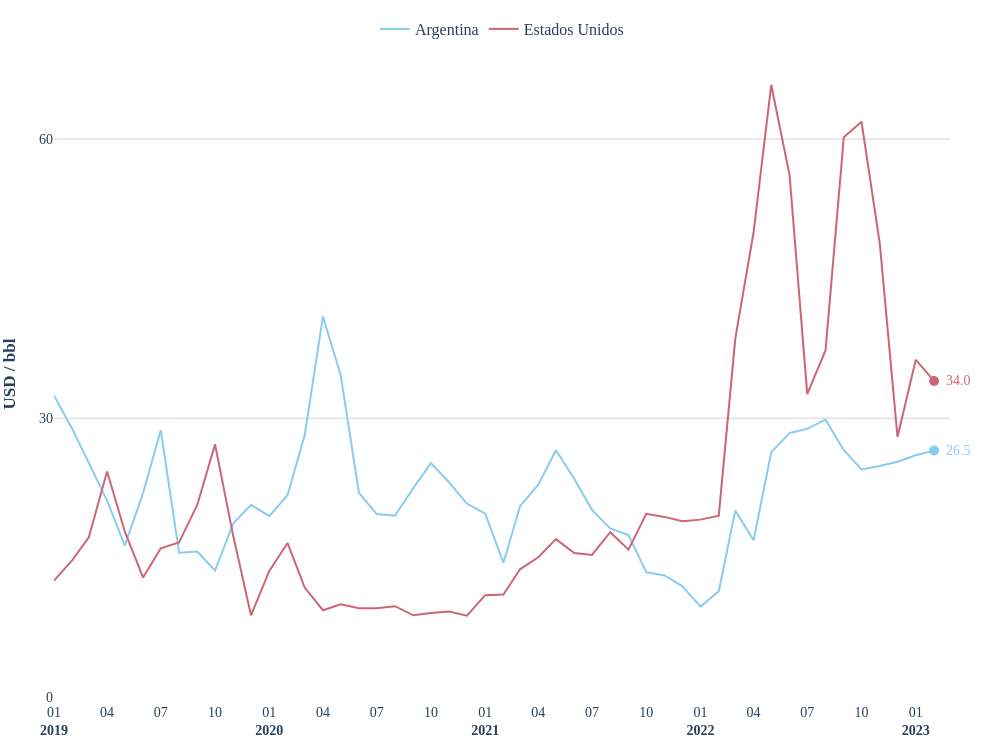

In [217]:
crack_spread.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [218]:
pio.write_image(crack_spread, "Figura Crack Spread.pdf", width=3*300, height=2.25*300)